In [30]:
import hydra
import torch
import pickle
import glob
from tqdm import tqdm
from sklearn.decomposition import PCA
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_cfg_from_from_ckpt_path
import re

from src.utils import *
from src.model.autoencoder.AE_CNN_pool_2D import AE_CNN_pool_2D

In [14]:
plt.style.use('ggplot')

In [15]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [16]:
def explicit_ecs(ssp: torch.tensor,
                 depth_tens: torch.tensor,
                 tau = 100):
    ssp = ssp.unsqueeze(1).nan_to_num()          
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    
        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    return ecs_pred

In [17]:
load_data = True

In [18]:
model_ckpt_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_0_var_0_gradient_1_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_25/None/2024-07-12_16-05/checkpoints/val_loss=0.00-epoch=00.ckpt"

In [19]:
gpu = 1
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [20]:
cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = True)

```yaml

datamodule:
  _target_: src.data.BaseDatamodule
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssf_ecs_da, ecs_da_path: '${paths.variables}',
    ssf_da_path: '${paths.sound}'}
  norm_stats: {method: mean_std, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 2D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dm: '${datamodule}', lit_mod: '${model}', trainer: '${trainer}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  loss_weight: {ecs_weight: 0, gradient_weight: 1, prediction_weight: 0, variation_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.01, weight_decay: 0.001}
model_architecture: AE_CNN_pool
model_config:
  accumulate_grad_batches: {2D: 1, 3D: 4}
  batch_size: {2D: 4, 3D: 1}
  model_hparams:
    AE_CNN_2D:
      act_fn_str: None
      base_channels: 107
      batch_norm: false
      dropout_proba: 0
      dtype_str: float32
      latent_dim: 3
      linear_layer: true
      num_layers: 5
      spatial_dim: [107, 240, 240]
    AE_CNN_3D:
      act_fn_str: None
      base_channels: 1
      batch_norm: false
      dropout_proba: 0
      dtype_str: float32
      latent_dim: 3
      linear_layer: true
      num_layers: 5
      spatial_dim: [107, 240, 240]
    AE_CNN_pool_2D: {act_fn_str: None, dropout_proba: 0, dtype_str: float32, final_act_fn_str: None,
      input_channels: 107, latent_dim: 9, num_layers: 1, pooling_str: None}
    ECS_explicit_pred_3D:
      depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  save_dir:
    AE_CNN: {version: 'latent_dim_${model.model_hparams.latent_dim}_num_layers_${model.model_hparams.num_layers}_linear_${model.model_hparams.linear_layer}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
    AE_CNN_pool: {version: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/${model.model_hparams.act_fn_str}/${now:%Y-%m-%d_%H-%M}'}
normalization:
  mean_std: {mean: null, std: null}
  min_max: {x_max: 1545.8698054910844, x_min: 1459.0439165829073}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc, variables: /DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc}
patience: 25
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: '${patience}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: false,
    name: '${model.model_name}/pred_${model.loss_weight.prediction_weight}_var_${model.loss_weight.variation_weight}_gradient_${model.loss_weight.gradient_weight}_ecs_${model.loss_weight.ecs_weight}',
    save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs/AE_V2/",
    version: '${model_config.save_dir.${model_architecture}.version}'}
  max_epochs: 1
  min_epochs: 0


```

In [21]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="fit") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api

In [22]:
depth_array = dm.train_dataloader().dataset.input.z.data

train_ssp_ds = dm.train_dataloader().dataset.input
train_ssp_ds_drop_na = train_ssp_ds.dropna(dim='lat')
train_ssp_arr = train_ssp_ds.data
input_train_shape = train_ssp_arr.shape


train_ssp_tens = torch.nan_to_num(torch.tensor(train_ssp_arr)).float().to(device)

In [23]:
dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api

In [24]:
test_ssp_ds = dm.test_dataloader().dataset.input
#test_ssp_arr = np.nan_to_num(test_ssp_arr)
test_ssp_ds_drop_na = test_ssp_ds.dropna(dim='lat')
test_ssp_arr = test_ssp_ds_drop_na.data
input_test_shape = test_ssp_arr.shape

test_ssp_tens = torch.nan_to_num(torch.tensor(test_ssp_ds.data)).float().to(device)

error with np.nan_to_num()
    train
        ecs = 13m
        ssp = 1.6e-16
    test
        ecs = 10m
        ssp = 1.6e-16


error with dropna(lat)
    train
        ecs = 0m
        ssp = 1.3e-16
    test
        ecs = 0m
        ssp = 1.3e-16

In [27]:
if not load_data:
    rmse_dict_ssp_per_componnents = {}
    rmse_dict_ecs_per_components = {}
    n_components_list = [i for i in range(1, 16)] + [30, 50, 100, 107]
    for n_components in tqdm(n_components_list, unit = "components", desc = "Computing ECS error per PCA components"):
        print(f"PCA over {n_components} components")
        pca = PCA(n_components = n_components, svd_solver = 'auto')
        pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107))
        output_test_decoded_pca =  pca.inverse_transform(pca.transform(test_ssp_arr.transpose(0,2,3,1).reshape(-1,input_test_shape[1]))).reshape(input_test_shape[0],input_test_shape[2],input_test_shape[3],-1).transpose(0,3,1,2)
        #output_test_decoded_pca = output_test_decoded_pca*(x_testx_max - x_min)+ x_min

        ecs_truth = explicit_ecs(torch.tensor(test_ssp_arr).float(),torch.tensor(depth_array).float())
        ecs_pred = explicit_ecs(torch.tensor(output_test_decoded_pca).float(),torch.tensor(depth_array).float())

        rmse_dict_ecs_per_components[n_components]= torch.sqrt(torch.mean((ecs_truth - ecs_pred)**2)).item()
        rmse_dict_ssp_per_componnents[n_components]= np.sqrt(np.mean((test_ssp_arr - output_test_decoded_pca)**2))

    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_ecs.pkl", "wb") as file:
        pickle.dump(rmse_dict_ecs_per_components, file)   
    
    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_celerity.pkl", "wb") as file:
        pickle.dump(rmse_dict_ssp_per_componnents, file)    
        

else:
   
    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_ecs.pkl", "rb") as file:
        rmse_dict_ecs_per_components = pickle.load(file)    
    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_celerity.pkl", "rb") as file:
        rmse_dict_ssp_per_componnents = pickle.load(file)    
        
        
rmse_pca_per_components_dict = dict(ssp = rmse_dict_ssp_per_componnents,
                                    ecs = rmse_dict_ecs_per_components)

In [15]:
rmse_dict_ecs_per_components

{1: 124.35702514648438,
 2: 124.35963439941406,
 3: 119.75659942626953,
 4: 113.76172637939453,
 5: 116.24610900878906,
 6: 116.90361022949219,
 7: 111.90877532958984,
 8: 114.38079833984375,
 9: 114.43750762939453,
 10: 104.677734375,
 11: 94.85345458984375,
 12: 102.53518676757812,
 13: 86.22711181640625,
 14: 82.0020523071289,
 15: 78.09422302246094,
 30: 37.69799041748047,
 50: 19.556400299072266,
 100: 5.223404884338379,
 107: 0.0}

In [16]:
rmse_dict_ssp_per_componnents

{1: 0.0484877919259228,
 2: 0.022000233863827615,
 3: 0.012986078650990999,
 4: 0.0068433302861287135,
 5: 0.0050476143774359754,
 6: 0.0036100772194207135,
 7: 0.0027547313408118504,
 8: 0.0022788677787840476,
 9: 0.0019095718898650214,
 10: 0.0016229827474389738,
 11: 0.001396269984444889,
 12: 0.0012066595189322653,
 13: 0.0010571774005751708,
 14: 0.0009352901914977121,
 15: 0.000826392457257819,
 30: 0.00021828502905665842,
 50: 7.108735289698372e-05,
 100: 3.3460501638801267e-06,
 107: 1.055856755083486e-16}

In [17]:
def plot_RMSE_per_PCA_components(rmse_pca_per_components_dict: dict,
                                 rmse_ae_per_components_dict: dict):

    fig,axs = plt.subplots(1,2,figsize=(18,8))
    #plt.figure(figsize=(10, 8))
    style = ['-', '--', '-.', ':']
    #colors = ['olive','deepskyblue','orchid','mediumseagreen']
    colors = ['olive', 'mediumblue', 'orchid', 'coral',
              'gold','lightskyblue', 'deepskyblue', 
              'yellowgreen', 'tomato', 'navy', 
              'orange', 'dodgerblue', 'royalblue', 'mediumseagreen'
              ]
    
    rmse_pca_ssp = rmse_pca_per_components_dict['ssp']
    rmse_pca_ecs = rmse_pca_per_components_dict['ecs']
    
    rmse_ae_ssp = rmse_ae_per_components_dict['ssp']
    rmse_ae_ecs = rmse_ae_per_components_dict['ecs']
    bottleneck_shape_dict = rmse_ae_per_components_dict["bottleneck_shape"]
    #ae_bottleneck_shape = rmse_ae_per_components_dict['bottleneck_shape']
    


    # Plot the data
    axs[0].plot(list(rmse_pca_ssp.keys()), list(rmse_pca_ssp.values()), label='pca', c='r')
    axs[1].plot(list(rmse_pca_ecs.keys()), list(rmse_pca_ecs.values()), label='pca', c='r')

    i = 0
    
    for model in rmse_ae_ssp.keys():

        
        for architecture in rmse_ae_ssp[model].keys():
            

            
            if architecture == "AE_CNN_pool_2D":
                
                spec = (": ").join([model.split('_')[-3],model.split('_')[-1]])
            
                for bottleneck_shape in rmse_ae_ssp[model][architecture].keys(): 
                
                    for j,act_fn_str in enumerate(rmse_ae_ssp[model][architecture][bottleneck_shape].keys()):
                        
                        for loss_weight in rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str].keys():
                            
                            bottleneck_label = bottleneck_shape_dict[model][architecture][bottleneck_shape][act_fn_str][loss_weight]

                            axs[0].plot(list(rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str][loss_weight].keys()), list(rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str][loss_weight].values()), 
                                        label=f'Bottleneck: (n° cmpts, {bottleneck_label[-2]}, {bottleneck_label[-1]}), {spec}, act fn: {act_fn_str}, loss weight: (pred={loss_weight[0]}, var={loss_weight[1]}, ecs={loss_weight[2]})', 
                                        c=colors[(i)%len(colors)], 
                                        ls = style[(j)%len(style)]
                                        )
                            axs[1].plot(list(rmse_ae_ecs[model][architecture][bottleneck_shape][act_fn_str][loss_weight].keys()), list(rmse_ae_ecs[model][architecture][bottleneck_shape][act_fn_str][loss_weight].values()),
                                        label=f'Bottleneck: (n° cmpts, {bottleneck_label[-2]}, {bottleneck_label[-1]}), act fn: {act_fn_str}, loss weight: (pred={loss_weight[0]}, var={loss_weight[1]}, ecs={loss_weight[2]})',
                                        c=colors[(i)%len(colors)],
                                        ls = style[(j)%len(style)])
                            
                            i = i+1
            
            
            
            elif architecture == "AE_CNN_3D":
                
                spec = (": ").join(model.split('_')[-2:])
                                
                if model.split('_')[-1:][0] == "False":
                    

                    
                    for bottleneck_shape in rmse_ae_ssp[model][architecture].keys(): 
                
                        for j,act_fn_str in enumerate(rmse_ae_ssp[model][architecture][bottleneck_shape].keys()):
                            
                            for loss_weight in rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str].keys():
                                
                                bottleneck_label = bottleneck_shape_dict[model][architecture][bottleneck_shape][act_fn_str][loss_weight]
                                
                                axs[0].hlines(list(rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str][loss_weight].values()),
                                              xmin = 0, 
                                              xmax=107,
                                              label=f'Bottleneck: ({bottleneck_label[-3]}, {bottleneck_label[-2]}, {bottleneck_label[-1]}), {spec}, act fn: {act_fn_str}, loss weight: (pred={loss_weight[0]}, var={loss_weight[1]}, ecs={loss_weight[2]})', 
                                              colors=colors[(i)%len(colors)], 
                                              linestyle = style[(j)%len(style)]
                                              )
                                
                                axs[1].hlines(list(rmse_ae_ecs[model][architecture][bottleneck_shape][act_fn_str][loss_weight].values()),
                                              xmin = 0, 
                                              xmax=107,
                                              label=f'Bottleneck: ({bottleneck_label[-3]}, {bottleneck_label[-2]}, {bottleneck_label[-1]}), {spec}, act fn: {act_fn_str}, loss weight: (pred={loss_weight[0]}, var={loss_weight[1]}, ecs={loss_weight[2]})', 
                                              colors=colors[(i)%len(colors)], 
                                              linestyle = style[(j)%len(style)]
                                              )
                                
                                i = i+1
                                
                                                    

                else:

                    for bottleneck_shape in rmse_ae_ssp[model][architecture].keys(): 
                
                        for j,act_fn_str in enumerate(rmse_ae_ssp[model][architecture][bottleneck_shape].keys()):
                            
                            for loss_weight in rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str].keys():
                                
                                bottleneck_label = bottleneck_shape_dict[model][architecture][bottleneck_shape][act_fn_str][loss_weight]
                                
                                axs[0].hlines(list(rmse_ae_ssp[model][architecture][bottleneck_shape][act_fn_str][loss_weight].values()),
                                                xmin = 0, 
                                                xmax=107,
                                                label=f'Bottleneck: ({bottleneck_label[-1]}), {spec}, act fn: {act_fn_str}, loss weight: (pred={loss_weight[0]}, var={loss_weight[1]}, ecs={loss_weight[2]})', 
                                                colors=colors[(i)%len(colors)], 
                                                linestyle = style[(j)%len(style)]
                                                )
                                
                                axs[1].hlines(list(rmse_ae_ecs[model][architecture][bottleneck_shape][act_fn_str][loss_weight].values()),
                                                xmin = 0, 
                                                xmax=107,
                                                label=f'Bottleneck: ({bottleneck_label[-1]}), {spec}, act fn: {act_fn_str}, loss weight: (pred={loss_weight[0]}, var={loss_weight[1]}, ecs={loss_weight[2]})', 
                                                colors=colors[(i)%len(colors)], 
                                                linestyle = style[(j)%len(style)]
                                                )
                                
                                i = i+1
                            


    # Add labels and title
    # ticks = np.arange(0, 101, 20)
    # axs[0].set_xticks(ticks)
    # axs[1].set_xticks(ticks)
    # axs[0].set_xticklabels(ticks)
    # axs[1].set_xticklabels(ticks)
    axs[0].set_xlabel('n° components')
    axs[1].set_xlabel('n° components')
    axs[0].set_ylabel('RMSE (normalized)')
    axs[1].set_ylabel('RMSE (m)')
    axs[0].set_title('Sound Speed', fontsize = 13)
    axs[1].set_title('ECS', fontsize = 13)
    axs[0].legend(fontsize = 7)
    axs[1].legend(fontsize = 7)

    fig.suptitle('RMSE per depth encoding components', y = 0.97, fontsize = 15)


In [18]:
def get_AE_rmse_ssp_ecs_per_compo(model_list: list,
                                  architecture: str = "**",
                                  loss_weight_list: list[(int,int,int)] = [("*","*","*")],
                                  act_fn_str: str = "**"):
    

    rmse_ecs_ae = {key: {} for key in model_list}
    rmse_ssp_ae = {key: {} for key in model_list}
    ae_bottleneck_shape = {key: {} for key in model_list}


    for model in model_list:

        for loss_weight in loss_weight_list:
            ckpt_list = glob.glob(f"/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/{architecture}/pred_{loss_weight[0]}_var_{loss_weight[1]}_ecs_{loss_weight[2]}/{model}/{act_fn_str}/**/*.ckpt", recursive=True)
            for ckpt_path in tqdm(ckpt_list,  unit = "model", desc = "Computing ECS error per model components"):
                #model_key = ckpt_path.split("/")[-5].split("latent_dim")
                n_components = int(ckpt_path.split("latent_dim_")[-1].split("_")[0])
                cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = False)   
                act_fn_str_model = cfg["model_config"]["model_hparams"][f"{cfg.model_architecture}_{cfg.dimensions}"]["act_fn_str"]
                #x_min, x_max = cfg.normalization.x_min, cfg.normalization.x_max
                architecture_key = cfg["model"]["model_name"]
                lit_model = load_model(ckpt_path, device)
                ssp_pred = lit_model(test_ssp_tens)
                ae_bottleneck_key = tuple(lit_model.encoder(test_ssp_tens).shape)[-2:]
                ecs_truth = explicit_ecs(test_ssp_tens,torch.tensor(depth_array).float())
                ecs_pred = explicit_ecs(ssp_pred,torch.tensor(depth_array).float())
                
                
                
                if architecture_key not in rmse_ecs_ae[model].keys():
                    rmse_ecs_ae[model][architecture_key] = {}
                    rmse_ssp_ae[model][architecture_key] = {} 
                    ae_bottleneck_shape[model][architecture_key] = {}
                    
                    
                if ae_bottleneck_key not in rmse_ecs_ae[model][architecture_key].keys():
                    rmse_ecs_ae[model][architecture_key][ae_bottleneck_key] = {}
                    rmse_ssp_ae[model][architecture_key][ae_bottleneck_key] = {}        
                    ae_bottleneck_shape[model][architecture_key][ae_bottleneck_key] = {}
                    
                
                if act_fn_str_model not in rmse_ecs_ae[model][architecture_key][ae_bottleneck_key].keys():
                    rmse_ecs_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model] = {}
                    rmse_ssp_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model] = {}
                    ae_bottleneck_shape[model][architecture_key][ae_bottleneck_key][act_fn_str_model] = {}
                    
                
                                
                if "*" in loss_weight:
                    match = re.search(r'pred_(\d+)_var_(\d+)_ecs_(\d+)', ckpt_path)
                    if match:
                        loss_weight_key = tuple(map(int, match.groups()))
                
                else : 
                    loss_weight_key = loss_weight
                
                if loss_weight_key not in rmse_ecs_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model].keys():
                    rmse_ecs_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model][loss_weight_key] = {}
                    rmse_ssp_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model][loss_weight_key] = {}
                    ae_bottleneck_shape[model][architecture_key][ae_bottleneck_key][act_fn_str_model][loss_weight_key] = tuple(lit_model.encoder(test_ssp_tens).shape)
                    
                
                rmse_ecs_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model][loss_weight_key][n_components]= torch.sqrt(torch.mean((ecs_truth - ecs_pred)**2)).item()
                rmse_ssp_ae[model][architecture_key][ae_bottleneck_key][act_fn_str_model][loss_weight_key][n_components]= torch.sqrt(torch.mean((test_ssp_tens - ssp_pred)**2)).item() #*(x_max - x_min)+ x_min

                       
                
    rmse_ae_per_components_dict = dict(ssp = rmse_ssp_ae,
                                       ecs = rmse_ecs_ae,
                                       bottleneck_shape = ae_bottleneck_shape)

    plot_RMSE_per_PCA_components(rmse_pca_per_components_dict, rmse_ae_per_components_dict)
    
    
    return rmse_ae_per_components_dict

Computing ECS error per model components: 100%|██████████| 239/239 [08:19<00:00,  2.09s/model]


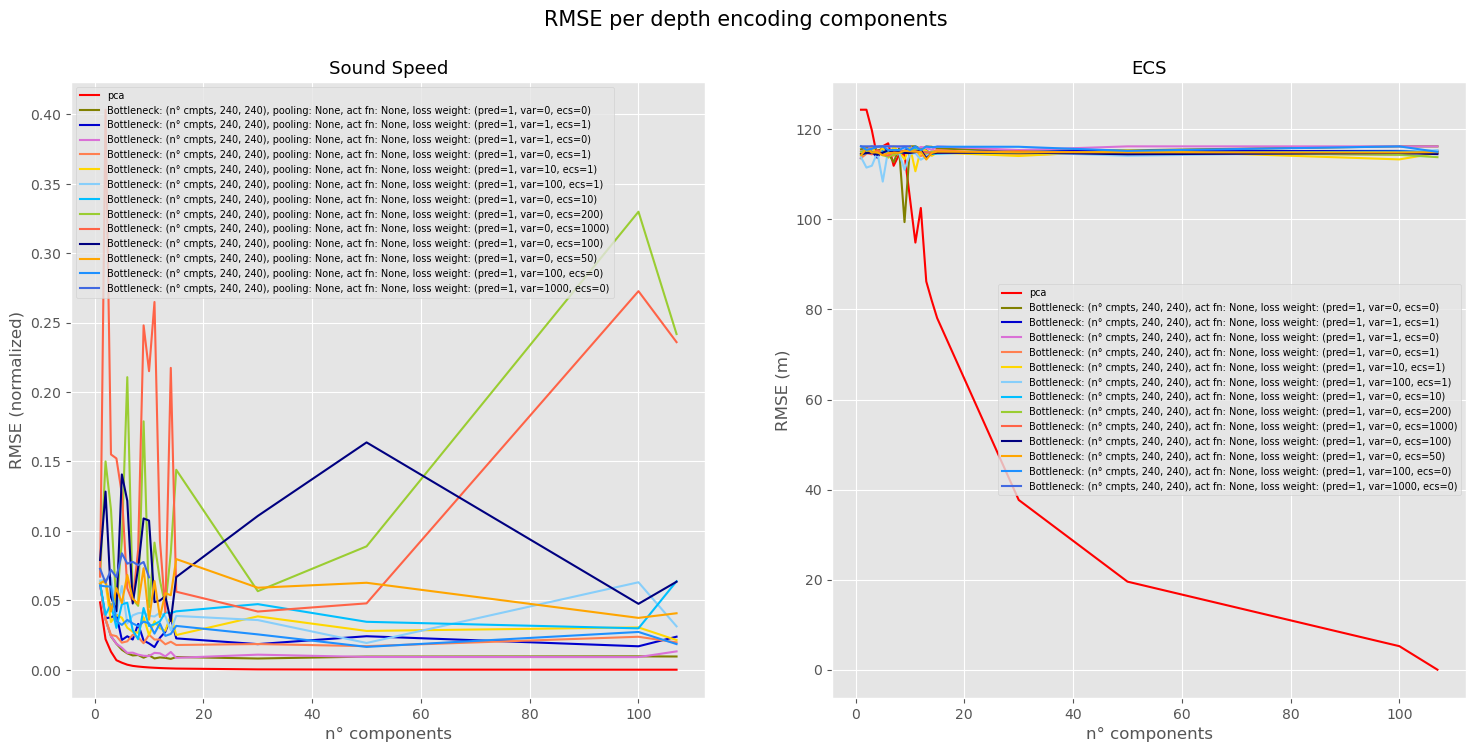

In [27]:
model_list = ["latent_dim_*_pooling_1_None"]
act_fn_str = "None"
loss_weight_list = [("*","*","*")]
rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str=act_fn_str, loss_weight_list=loss_weight_list)

Computing ECS error per model components: 100%|██████████| 19/19 [00:39<00:00,  2.07s/model]


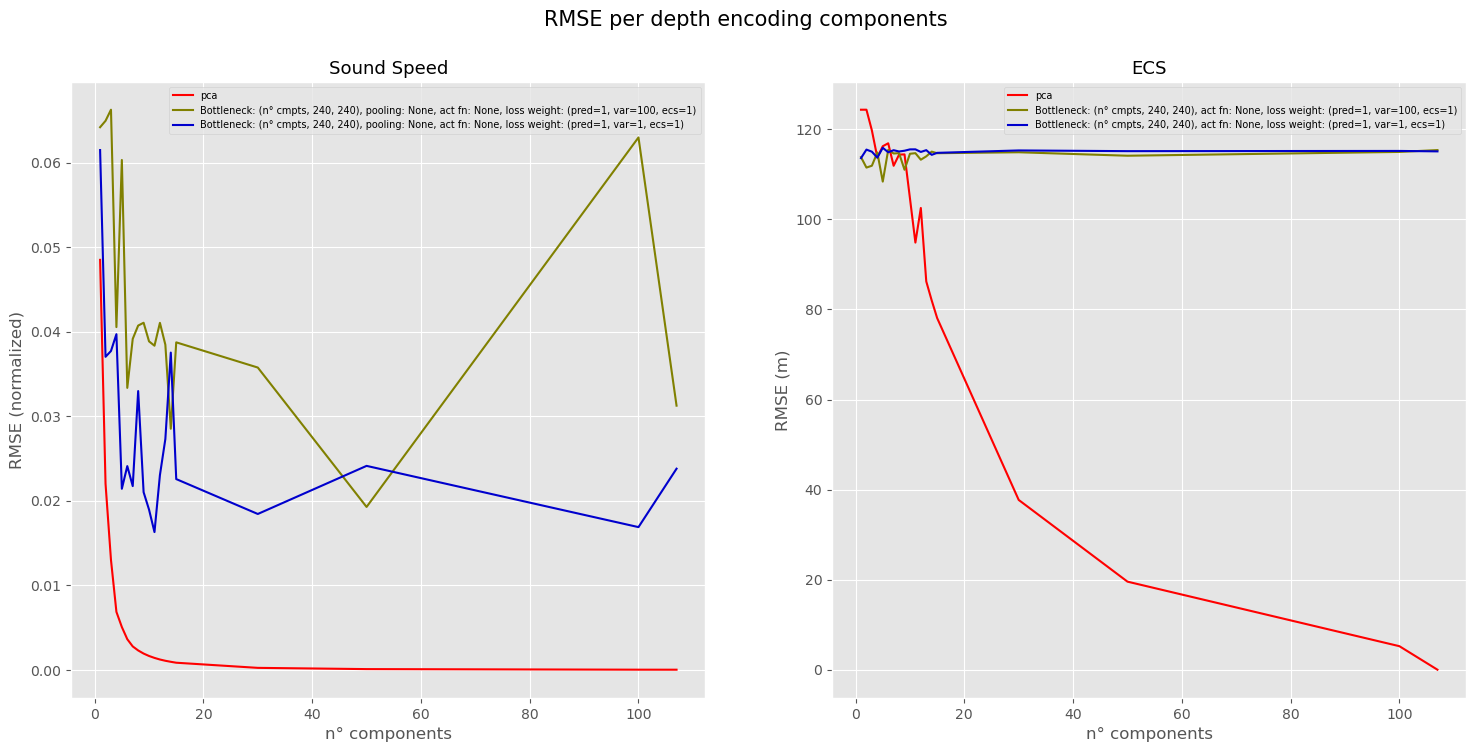

In [28]:
model_list = ["latent_dim_*_pooling_1_None"]

act_fn_str = "None"
loss_weight_list = [(1,100,1),(1,1,1)]
rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str=act_fn_str, loss_weight_list=loss_weight_list)

Computing ECS error per model components: 100%|██████████| 152/152 [05:20<00:00,  2.11s/model]


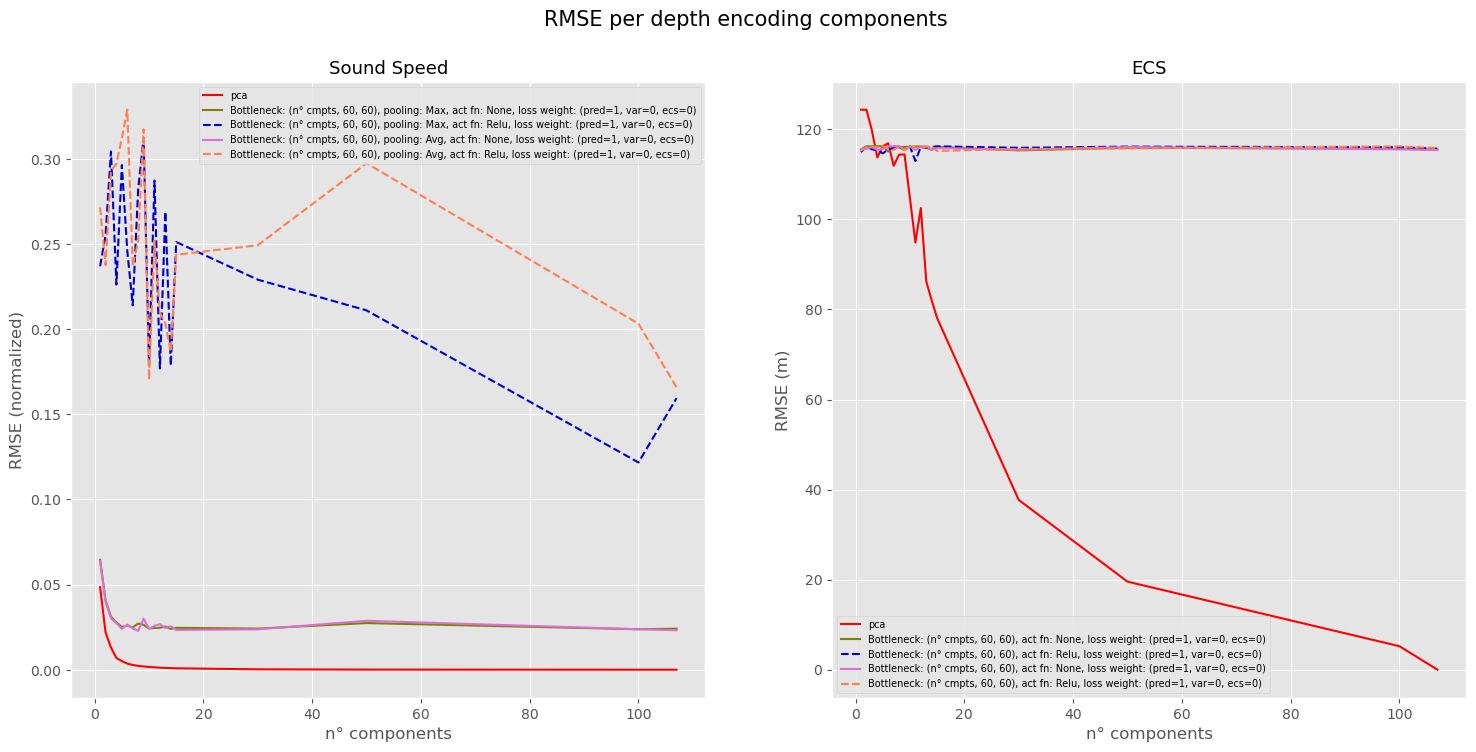

In [29]:
model_list = ["latent_dim_*_pooling_2_Max",
              "latent_dim_*_pooling_2_Avg"]
act_fn_str = "**"
loss_weight_list = [("1","0","0")]
rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str=act_fn_str, loss_weight_list=loss_weight_list)

Computing ECS error per model components: 100%|██████████| 133/133 [04:37<00:00,  2.09s/model]


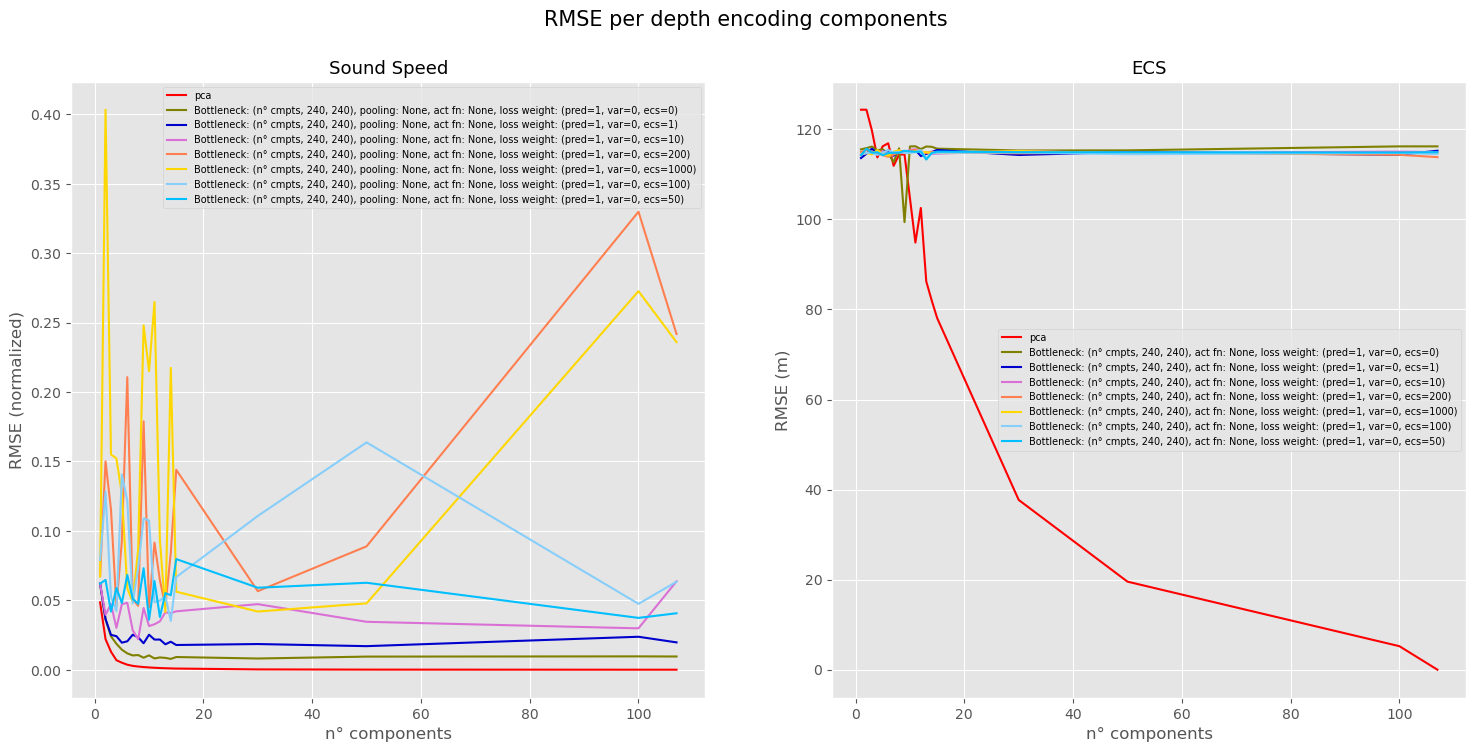

In [30]:
model_list = ["latent_dim_*_pooling_1_None"]  #"latent_dim_1_num_layers_5_linear_False"
act_fn_str = "None"
loss_weight_list = [("1","0","*")]

rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str = act_fn_str, loss_weight_list= loss_weight_list )

Computing ECS error per model components: 100%|██████████| 19/19 [00:39<00:00,  2.07s/model]


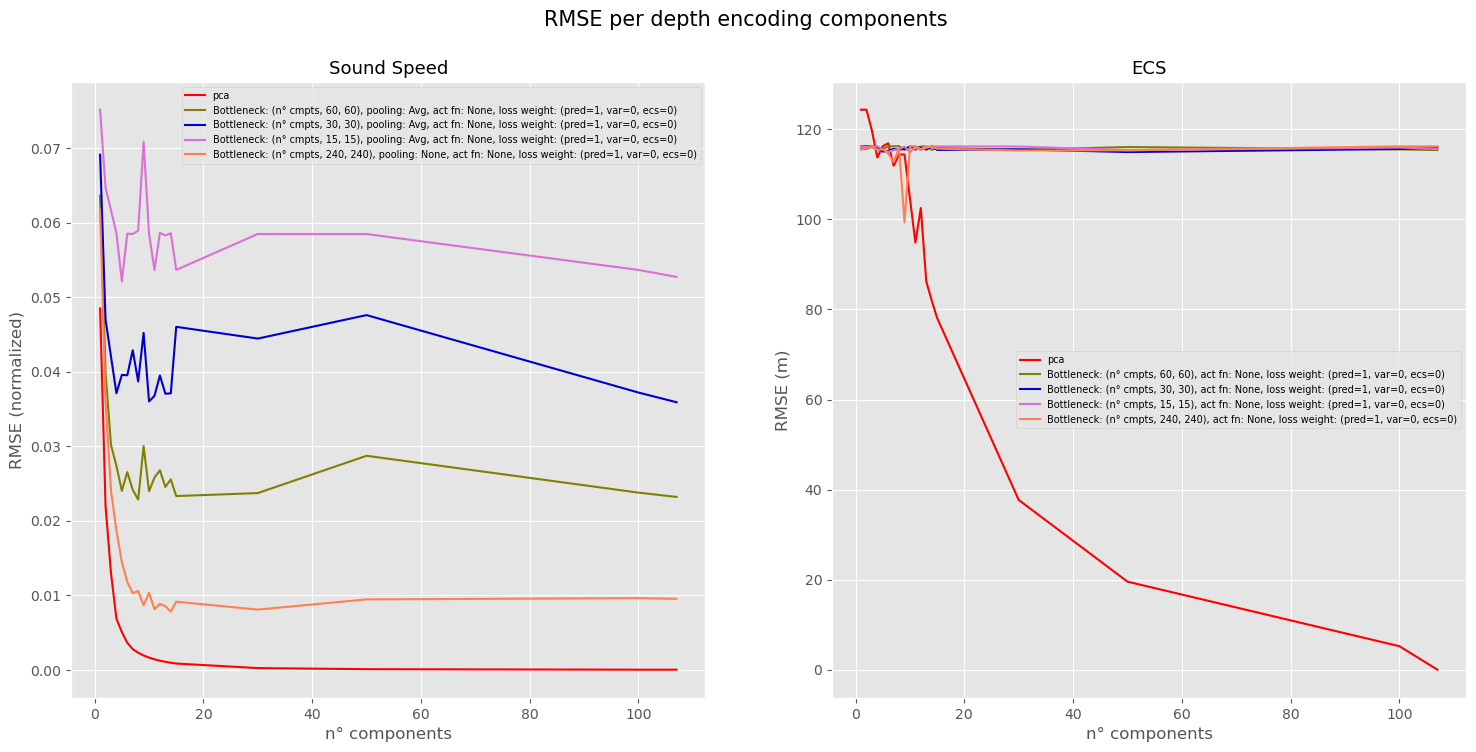

In [31]:
model_list = ["latent_dim_*_pooling_*_Avg",
              "latent_dim_*_pooling_1_None"]
act_fn_str = "None"
loss_weight_list = [("1","0","0")]

rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str = act_fn_str, loss_weight_list= loss_weight_list )

Computing ECS error per model components: 100%|██████████| 133/133 [04:39<00:00,  2.10s/model]


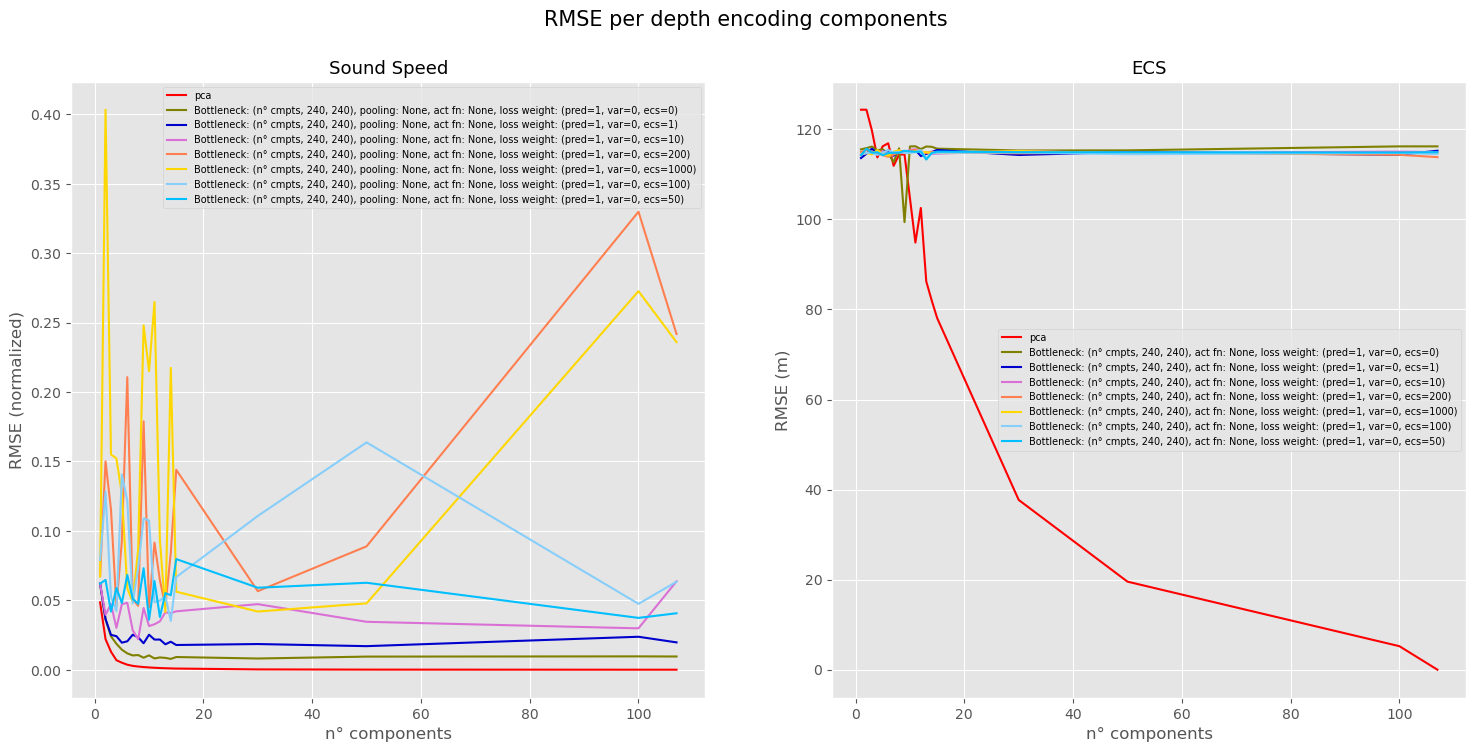

In [32]:
model_list = ["latent_dim_*_pooling_1_None"]
act_fn_str = "None"
loss_weight_list = [("1","0","*")]

rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str = act_fn_str, loss_weight_list= loss_weight_list )

Computing ECS error per model components: 100%|██████████| 5/5 [00:12<00:00,  2.41s/model]


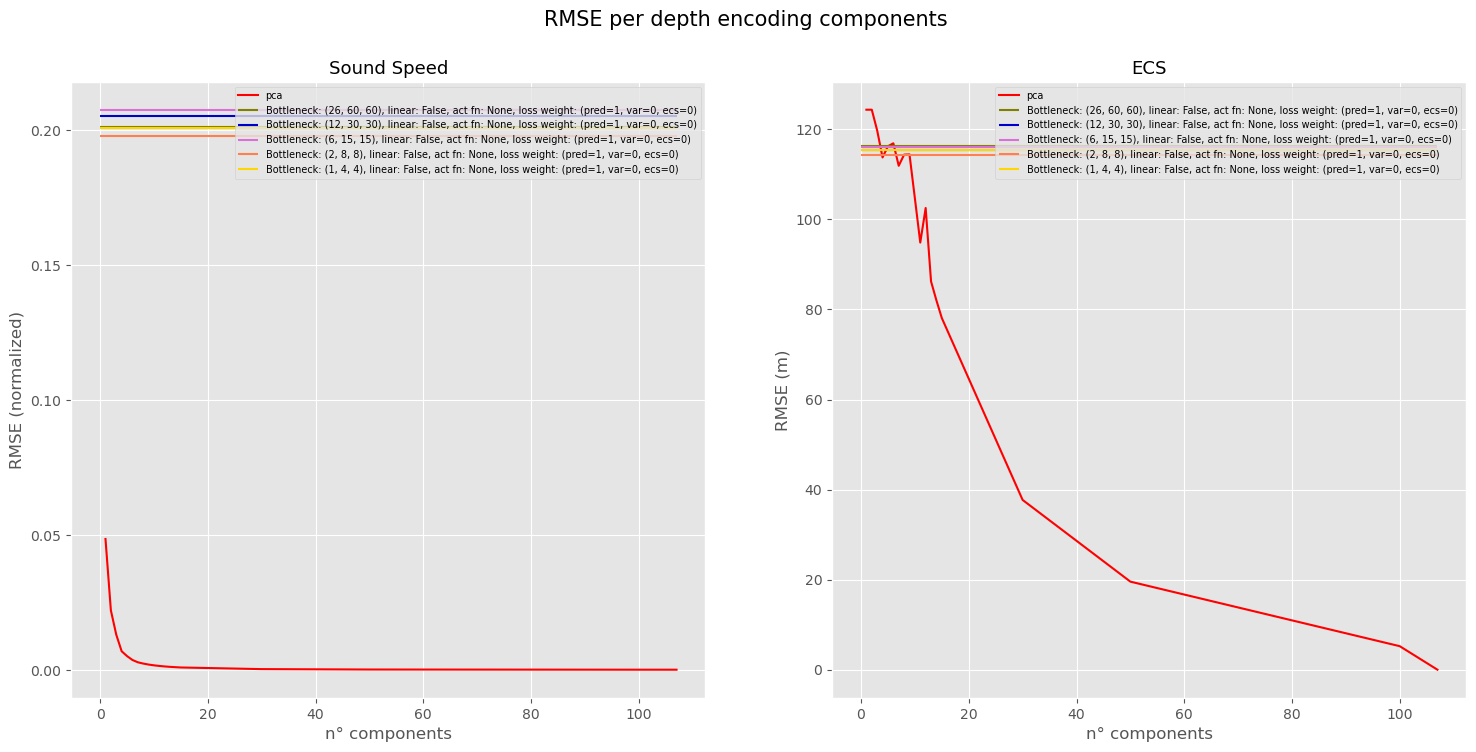

In [33]:
model_list = ["latent_dim_1_num_layers_*_linear_False"]  #"latent_dim_1_num_layers_5_linear_False"
act_fn_str = "None"
loss_weight_list = [("1","0","0")]

rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str = act_fn_str, loss_weight_list= loss_weight_list )

Computing ECS error per model components: 100%|██████████| 10/10 [00:22<00:00,  2.26s/model]


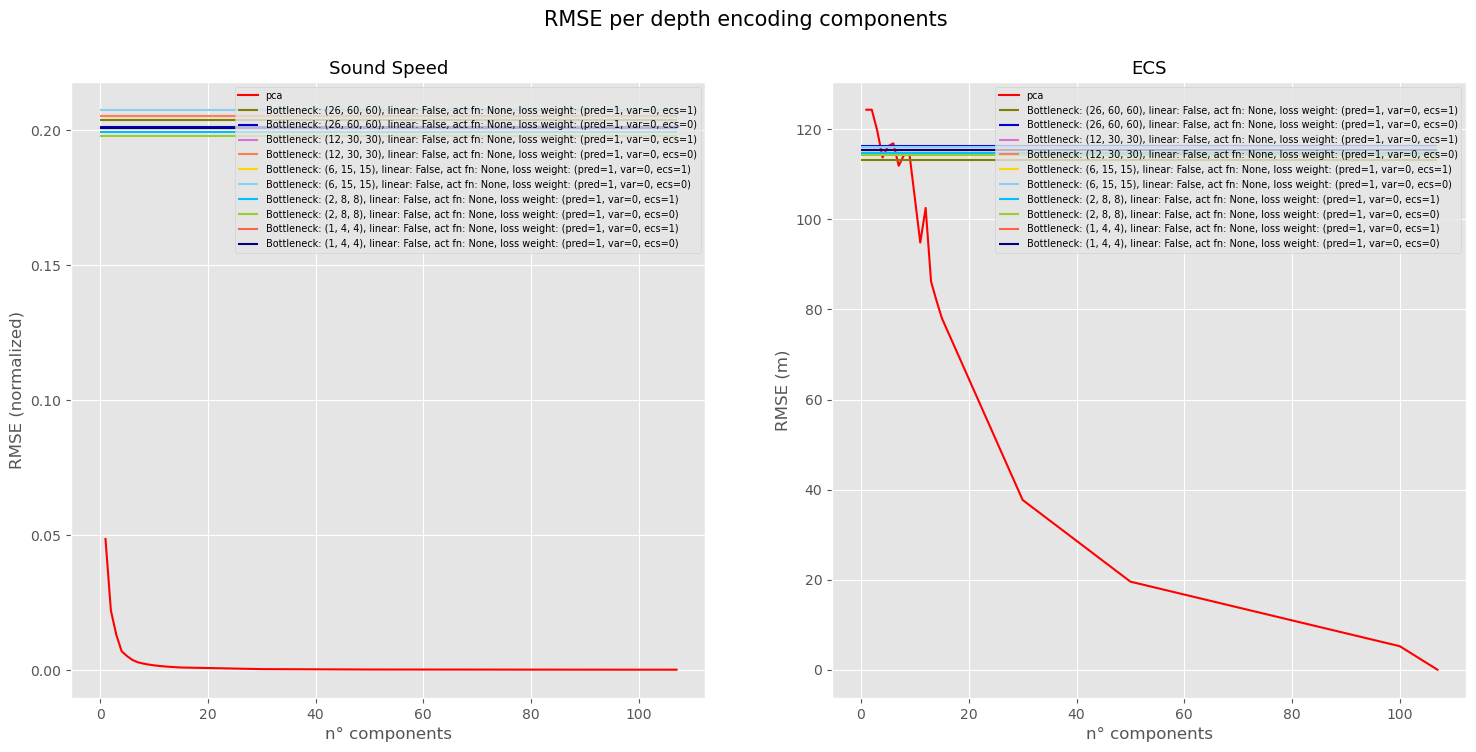

In [34]:
model_list = ["latent_dim_1_num_layers_*_linear_False"]  #"latent_dim_1_num_layers_5_linear_False"
act_fn_str = "None"
loss_weight_list = [("*","*","*")]

rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str = act_fn_str, loss_weight_list= loss_weight_list )

Computing ECS error per model components: 100%|██████████| 1/1 [00:02<00:00,  2.26s/model]


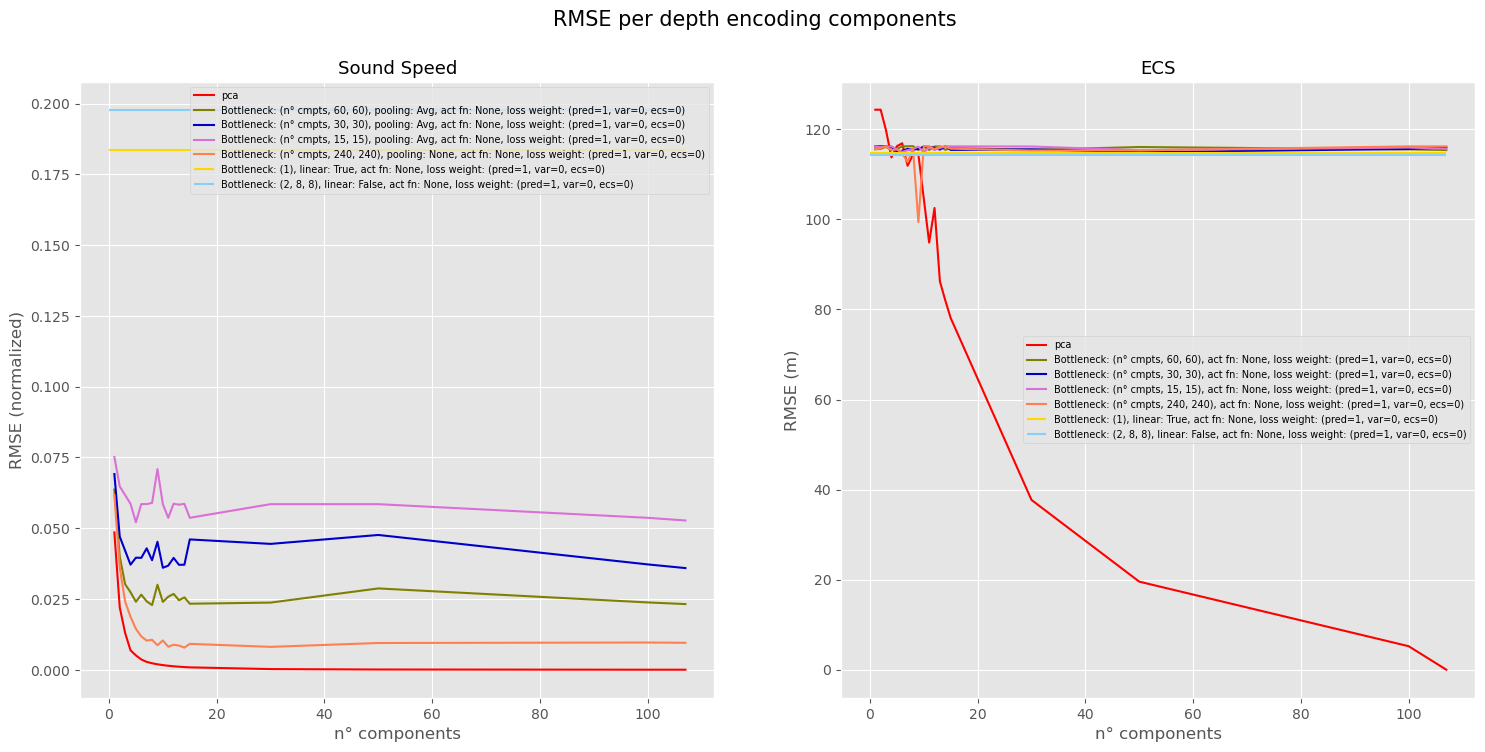

In [35]:
model_list = ["latent_dim_*_pooling_*_Avg",
              "latent_dim_*_pooling_1_None",
              "latent_dim_1_num_layers_2_linear_True",
              "latent_dim_1_num_layers_5_linear_False"]  #"latent_dim_1_num_layers_5_linear_False"
act_fn_str = "None"
loss_weight_list = [("1","0","0")]

rmse_ae_per_components_dict = get_AE_rmse_ssp_ecs_per_compo(model_list, act_fn_str = act_fn_str, loss_weight_list= loss_weight_list )

In [42]:
ckpt_list = ["/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_0_ecs_0/latent_dim_107_pooling_1_None_dropout_0_patience_2000/2024-07-15_19-39/checkpoints/val_loss=0.00-epoch=1999.ckpt",
             "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_0_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_2000/None/2024-07-16_18-19/checkpoints/val_loss=0.02-epoch=1908.ckpt",
             "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_100_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_2000/None/2024-07-16_17-07/checkpoints/val_loss=0.01-epoch=1997.ckpt",
             "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_pool_2D/pred_1_var_0_gradient_1000_ecs_0/latent_dim_9_pooling_1_None_dropout_0_patience_2000/None/2024-07-17_14-02/checkpoints/val_loss=0.07-epoch=1085.ckpt"
             ]
rmse_ecs_ae = {}
rmse_ssp_ae = {}
ae_bottleneck_shape = {}


for ckpt_path in tqdm(ckpt_list,  unit = "model", desc = "Computing ECS error per model components"):
    #model_key = ckpt_path.split("/")[-5].split("latent_dim")
    #n_components = int(ckpt_path.split("latent_dim_")[-1].split("_")[0])
    cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = False)   
    act_fn_str_model = cfg["model_config"]["model_hparams"][f"{cfg.model_architecture}_{cfg.dimensions}"]["act_fn_str"]
    #x_min, x_max = cfg.normalization.x_min, cfg.normalization.x_max
    architecture_key = cfg["model"]["model_name"]
    lit_model = load_model(ckpt_path, device)
    ssp_pred = lit_model(test_ssp_tens)
    ae_bottleneck_key = tuple(lit_model.encoder(test_ssp_tens).shape)[-2:]
    ecs_truth = explicit_ecs(test_ssp_tens,torch.tensor(depth_array).float())
    ecs_pred = explicit_ecs(ssp_pred,torch.tensor(depth_array).float())
    
    

        
    
    rmse_ecs_ae["_".join(ckpt_path.split("/")[9:13])]= torch.sqrt(torch.mean((ecs_truth - ecs_pred)**2)).item()
    rmse_ssp_ae["_".join(ckpt_path.split("/")[9:13])]= torch.sqrt(torch.mean((test_ssp_tens - ssp_pred)**2)).item() #*(x_max - x_min)+ x_min
    ae_bottleneck_shape["_".join(ckpt_path.split("/")[9:13])] = tuple(lit_model.encoder(test_ssp_tens).shape)
                    
            
  
model_hparams_dict = OmegaConf.to_container(cfg.model.model_hparams, resolve=True)
model_hparams_dict["init_params"]["params"] = get_convo_init_weight_bias("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_mean_and_components.pkl")



model_hparams_dict["latent_dim"] = 9
lit_model = AE_CNN_pool_2D(**model_hparams_dict).to(device).eval()
ssp_pred = lit_model(test_ssp_tens)
ecs_truth = explicit_ecs(test_ssp_tens,torch.tensor(depth_array).float())
ecs_pred = explicit_ecs(ssp_pred,torch.tensor(depth_array).float())
rmse_ecs_ae["no training 9"]= torch.sqrt(torch.mean((ecs_truth - ecs_pred)**2)).item()
rmse_ssp_ae["no training 9"]= torch.sqrt(torch.mean((test_ssp_tens - ssp_pred)**2)).item()
ae_bottleneck_shape["no training 9"] = tuple(lit_model.encoder(test_ssp_tens).shape)


model_hparams_dict["latent_dim"] = 107
lit_model = AE_CNN_pool_2D(**model_hparams_dict).to(device).eval()
ssp_pred = lit_model(test_ssp_tens)
ecs_truth = explicit_ecs(test_ssp_tens,torch.tensor(depth_array).float())
ecs_pred = explicit_ecs(ssp_pred,torch.tensor(depth_array).float())
rmse_ecs_ae["no training 107"]= torch.sqrt(torch.mean((ecs_truth - ecs_pred)**2)).item()
rmse_ssp_ae["no training 107"]= torch.sqrt(torch.mean((test_ssp_tens - ssp_pred)**2)).item()
ae_bottleneck_shape["no training 107"] = tuple(lit_model.encoder(test_ssp_tens).shape)


rmse_ae_per_components_dict = dict(ssp = rmse_ssp_ae,
                                    ecs = rmse_ecs_ae,
                                    bottleneck_shape = ae_bottleneck_shape)

#plot_RMSE_per_PCA_components(rmse_pca_per_components_dict, rmse_ae_per_components_dict)




Computing ECS error per model components: 100%|██████████| 4/4 [00:02<00:00,  1.60model/s]


Text(0.5, 0.97, 'RMSE per depth encoding components')

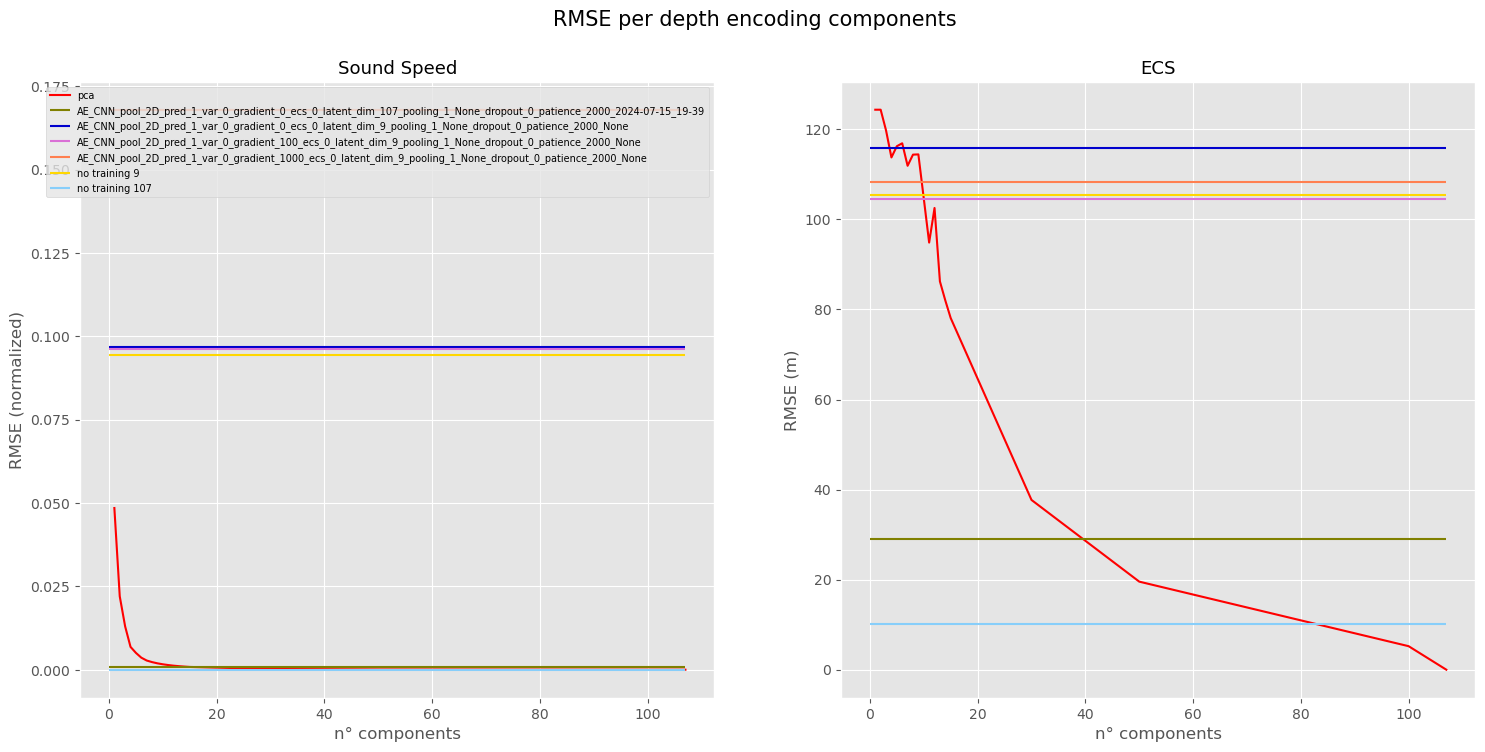

In [43]:

fig,axs = plt.subplots(1,2,figsize=(18,8))
#plt.figure(figsize=(10, 8))
style = ['-', '--', '-.', ':']
#colors = ['olive','deepskyblue','orchid','mediumseagreen']
colors = ['olive', 'mediumblue', 'orchid', 'coral',
            'gold','lightskyblue', 'deepskyblue', 
            'yellowgreen', 'tomato', 'navy', 
            'orange', 'dodgerblue', 'royalblue', 'mediumseagreen'
            ]

rmse_pca_ssp = rmse_pca_per_components_dict['ssp']
rmse_pca_ecs = rmse_pca_per_components_dict['ecs']

rmse_ae_ssp = rmse_ae_per_components_dict['ssp']
rmse_ae_ecs = rmse_ae_per_components_dict['ecs']
bottleneck_shape_dict = rmse_ae_per_components_dict["bottleneck_shape"]
#ae_bottleneck_shape = rmse_ae_per_components_dict['bottleneck_shape']



# Plot the data
axs[0].plot(list(rmse_pca_ssp.keys()), list(rmse_pca_ssp.values()), label='pca', c='r')
axs[1].plot(list(rmse_pca_ecs.keys()), list(rmse_pca_ecs.values()), label='pca', c='r')

i = 0

for model in rmse_ae_ssp.keys():

    bottleneck_label = bottleneck_shape_dict[model]

    axs[0].hlines(y = rmse_ae_ssp[model],
                  xmin = 0,
                  xmax=107,
                  label=f'{model}', 
                  colors=colors[(i)%len(colors)]
                  )
    
    axs[1].hlines(y =rmse_ae_ecs[model], 
                  xmin = 0, 
                  xmax=107,
            
                  label=f'{model}',
                  colors=colors[(i)%len(colors)])
    
    i = i+1
        
     
axs[0].set_xlabel('n° components')
axs[1].set_xlabel('n° components')
axs[0].set_ylabel('RMSE (normalized)')
axs[1].set_ylabel('RMSE (m)')
axs[0].set_title('Sound Speed', fontsize = 13)
axs[1].set_title('ECS', fontsize = 13)
axs[0].legend(fontsize = 7, loc = "upper right")
#axs[1].legend(fontsize = 7,loc = "lower right")

fig.suptitle('RMSE per depth encoding components', y = 0.97, fontsize = 15)

In [ ]:
rmse_ae_per_components_dict["ssp"]

{'AE_CNN_pool_2D_pred_1_var_0_ecs_0_latent_dim_107_pooling_1_None_None': 0.009508971124887466,
 'AE_CNN_pool_2D_pred_1_var_0_ecs_0_latent_dim_9_pooling_1_None_None': 0.00864280667155981,
 'AE_CNN_pool_2D_pred_1_var_0_ecs_0_latent_dim_9_pooling_1_None_dropout_0.1_None': 0.016267139464616776,
 'AE_CNN_pool_2D_pred_1_var_0_gradient_0_ecs_0_latent_dim_9_pooling_1_None_dropout_0_patience_1000_None': 0.008353008888661861,
 'AE_CNN_pool_2D_pred_1_var_0_gradient_100_ecs_0_latent_dim_9_pooling_1_None_dropout_0_None': 0.011892142705619335,
 'AE_CNN_pool_2D_pred_1_var_0_gradient_1000_ecs_0_latent_dim_9_pooling_1_None_dropout_0_None': 0.018339121714234352,
 'AE_CNN_pool_2D_pred_1_var_0_gradient_1000_ecs_0_latent_dim_9_pooling_1_None_dropout_0.2_None': 0.019684351980686188,
 'AE_CNN_pool_2D_pred_1_var_0_gradient_1000_ecs_0_latent_dim_9_pooling_1_None_dropout_0_patience_1000_None': 0.010228144004940987}